In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns  # noqa
from matplotlib import pyplot as plt  # noqa

In [3]:
df = pd.read_csv("dataset/diabetes.csv")
df.columns
df.head(5)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# split the dataset to training and testing set
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
X_train.shape, X_test.shape

((691, 8), (77, 8))

In [6]:
def get_dataframe(X, y, columns):
    return pd.DataFrame(np.c_[X, y], columns=columns)

In [7]:
df_train = get_dataframe(X_train, y_train, df.columns)
df_train.shape
df_train.info()

(691, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               691 non-null    float64
 1   Glucose                   691 non-null    float64
 2   BloodPressure             691 non-null    float64
 3   SkinThickness             691 non-null    float64
 4   Insulin                   691 non-null    float64
 5   BMI                       691 non-null    float64
 6   DiabetesPedigreeFunction  691 non-null    float64
 7   Age                       691 non-null    float64
 8   Outcome                   691 non-null    float64
dtypes: float64(9)
memory usage: 48.7 KB


array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

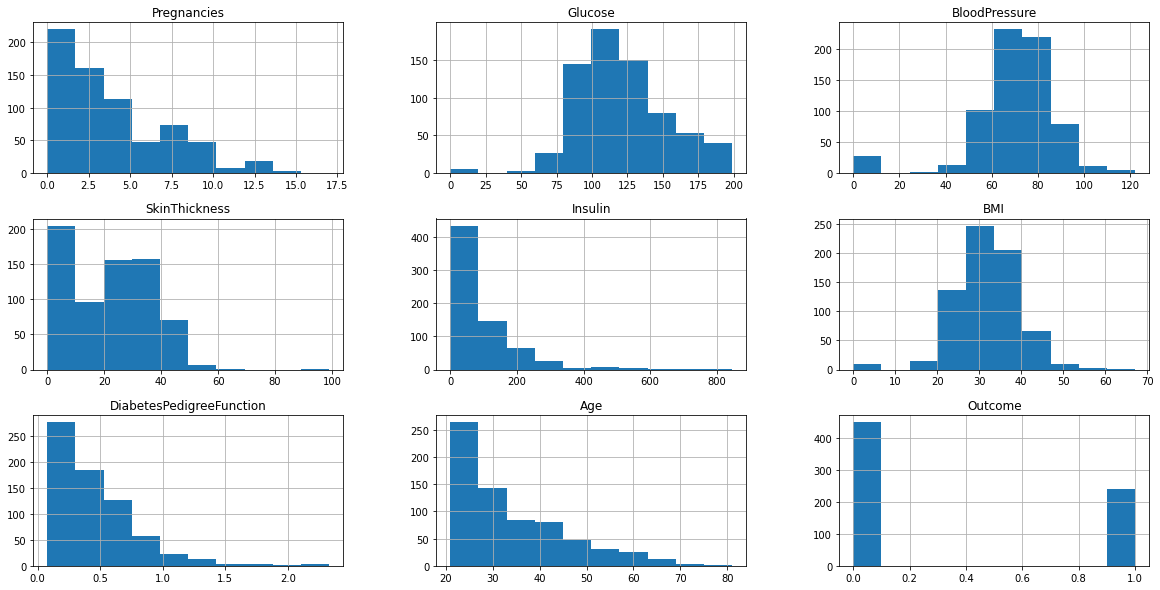

In [8]:
# plot the distribution of all the columns
df_train.hist(figsize=(20, 10))

## Custom Transformers

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin


class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.log(X)

In [10]:
class NormalDistOutlierDetecter(BaseEstimator, TransformerMixin):
    def __init__(self, lower_z, upper_z, alpha):
        self.lower_z = lower_z
        self.upper_z = upper_z
        self.alpha = alpha

    def fit(self, X, y):
        self.normally_dist_columns_ = self._get_normally_distributed_columns(X)
        return self

    # find the columns with values whose distribution seem to be Gaussian
    def _get_normally_distributed_columns(self, X):
        normally_dist_cols = []
        for col in X.columns:
            feature = X.loc[:, col]
            value_bins = min(feature.nunique(), 20)
            distribution = pd.cut(feature, bins=value_bins).value_counts(sort=False).values
            p_value = stats.normaltest(distribution)[1]
            if p_value >= self.alpha:
                normally_dist_cols.append(col)
        return normally_dist_cols

    def transform(self, X):
        for col_name in self.normally_dist_columns_:
            feature = X.loc[:, col_name]
            feature.loc[
                (stats.zscore(feature) < self.lower_z) | (stats.zscore(feature) > self.upper_z)
            ] = np.nan
            X.loc[:, col_name] = feature

        return X

In [11]:
class NonNormalDistOutlierDetecter(BaseEstimator, TransformerMixin):
    def __init__(self, q1, q2, alpha):
        self.q1 = q1
        self.q2 = q2
        self.alpha = alpha

    # The lower and upper limit should be persisted if this is going to be used
    # to transform the data in the testing set
    def fit(self, X, y):
        self.non_normal_dist_cols_ = self._get_non_normally_distributed_columns(X)
        self.boundaries_ = {}
        for col in self.non_normal_dist_cols_:
            feature = X.loc[:, col]
            lower_per_value = np.percentile(feature, self.q1)
            upper_per_value = np.percentile(feature, self.q2)
            iqr = upper_per_value - lower_per_value
            lower_limit = lower_per_value - (iqr * 1.5)
            upper_limit = upper_per_value + (iqr * 1.5)
            self.boundaries_[col] = (lower_limit, upper_limit)
        return self

    # find the columns with values whose distribution seem to be Gaussian
    def _get_non_normally_distributed_columns(self, X):
        non_normally_dist_cols = []
        for col in X.columns:
            feature = X.loc[:, col]
            value_bins = min(feature.nunique(), 20)
            distribution = pd.cut(feature, bins=value_bins).value_counts(sort=False).values
            p_value = stats.normaltest(distribution)[1]
            if p_value < self.alpha:
                non_normally_dist_cols.append(col)
        return non_normally_dist_cols

    def transform(self, X):
        for col, boundary in self.boundaries_.items():
            feature = X.loc[:, col]
            feature.loc[feature < boundary[0]] = np.nan
            feature.loc[feature > boundary[1]] = np.nan
            X.loc[:, col] = feature
        return X

In [12]:
class FeatureOutlierDetector(BaseEstimator, TransformerMixin):
    def __init__(self, q1, q2):
        self.q1 = q1
        self.q2 = q2

    # The lower and upper limit should be persisted if this is going to be used
    # to transform the data in the testing set
    def fit(self, X, y):
        self.boundaries_ = {}
        for col in X.columns:
            feature = X.loc[:, col]
            lower_per_value = np.percentile(feature, self.q1)
            upper_per_value = np.percentile(feature, self.q2)
            iqr = upper_per_value - lower_per_value
            lower_limit = lower_per_value - (iqr * 1.5)
            upper_limit = upper_per_value + (iqr * 1.5)
            self.boundaries_[col] = (lower_limit, upper_limit)
        return self

    def transform(self, X):
        for col, boundary in self.boundaries_.items():
            feature = X.loc[:, col]
            feature.loc[feature < boundary[0]] = boundary[0]
            feature.loc[feature > boundary[1]] = boundary[1]
            X.loc[:, col] = feature
        return X

In [13]:
# Column Interactions transformer
from typing import List, Mapping


class FeatureInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, feature_interactions: Mapping[str, List[str]]):
        self.feature_interactions = feature_interactions
        self.added_columns_ = []

    def fit(self, X, y):
        return self

    def transform(self, X):
        for feat1 in self.feature_interactions:
            for feat2 in self.feature_interactions[feat1]:
                self.added_columns_.append(f"{feat1}_{feat2}")
                X.loc[:, f"{feat1}_{feat2}"] = X[feat1] * X[feat2]
        return X

In [14]:
class ColumnStripper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

In [15]:
def perform_data_transformation(steps, X_train_t, y_train, feature_columns):
    for name, transformer, cols in steps:
        print(f"current step: {name}")
        if cols == feature_columns:
            X_train_t = pd.DataFrame(
                transformer.fit_transform(X_train_t, y_train), columns=feature_columns
            )
        else:
            X_train_t.loc[:, cols] = transformer.fit_transform(X_train_t.loc[:, cols], y_train)
    return X_train_t

In [16]:
from scipy import stats
from sklearn.impute import KNNImputer

X_train_t = df_train.drop(columns=["Outcome"])
y_train = df_train["Outcome"]
feature_columns = list(X_train_t.columns)

data_preprocessing_steps = [
    (
        "missing_value_imputer",
        KNNImputer(n_neighbors=10, missing_values=0),
        ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"],
    ),
    ("log_tranformer", LogTransformer(), ["Insulin", "SkinThickness", "DiabetesPedigreeFunction"]),
    #      ("normal_dist_outlier_detector", NormalDistOutlierDetecter(
    #         stats.norm.ppf(0.01),
    #         stats.norm.ppf(0.99),
    #         alpha=0.05), feature_columns),
    #      ("non_normal_dist_outlier_detector",  NonNormalDistOutlierDetecter(
    #         10,
    #         90,
    #         alpha=0.05
    # ), feature_columns),
    # ("outlier_imputer", KNNImputer(n_neighbors=10, weights="uniform"), feature_columns),
    ("feature_outlier_detector", FeatureOutlierDetector(10, 90), feature_columns),
]

X_train_t = perform_data_transformation(
    data_preprocessing_steps, X_train_t, y_train, feature_columns
)
X_train_t.shape
X_train_t.describe()

current step: missing_value_imputer
current step: log_tranformer
current step: feature_outlier_detector


(691, 8)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,3.875543,121.701881,72.143415,3.305151,4.834431,32.362026,-0.957500,33.410999
std,3.385240,30.291572,12.253094,0.346707,0.585252,6.736250,0.647248,11.759256
min,0.000000,44.000000,24.000000,1.945910,2.708050,18.200000,-2.551046,21.000000
25%,1.000000,99.000000,64.000000,3.124563,4.473351,27.600000,-1.408542,24.000000
50%,3.000000,117.000000,72.000000,3.342862,4.853592,32.100000,-0.972861,29.000000
75%,6.000000,139.500000,80.000000,3.555348,5.220356,36.500000,-0.465216,41.000000
max,17.000000,199.000000,122.000000,4.595120,6.740519,66.100000,0.845439,81.000000


In [17]:
# Identify outliers using LocalOutlierFactor
# Remove the outliers only from the training set
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
outliers = lof.fit_predict(X_train_t)

X_train_t = X_train_t.loc[outliers == 1]
y_train = y_train.loc[outliers == 1]

X_train_t.shape, y_train.shape
X_train_t.describe()

((673, 8), (673,))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000
mean,3.888559,122.083210,72.132392,3.302801,4.839149,32.245260,-0.957324,33.316493
std,3.368411,30.126383,11.076698,0.347818,0.582739,6.421751,0.648026,11.650771
min,0.000000,57.000000,44.000000,1.945910,2.708050,18.200000,-2.551046,21.000000
25%,1.000000,100.000000,64.000000,3.117950,4.477337,27.600000,-1.410587,24.000000
50%,3.000000,117.000000,72.000000,3.342862,4.859812,32.000000,-0.967584,29.000000
75%,6.000000,140.000000,80.000000,3.546740,5.220896,36.300000,-0.460449,41.000000
max,17.000000,199.000000,110.000000,4.595120,6.740519,53.200000,0.845439,81.000000


In [18]:
# scale the dataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# feature importances of all feature interactions using random forest classifier
#  ('Glucose_Age', 0.13329970172080755),
#  ('Glucose_Insulin', 0.11556997814180311),
#  ('Glucose_BMI', 0.11030499452531185),
#  ('Glucose', 0.07731734213231307),
#  ('Insulin', 0.07023585301064626),
#  ('Insulin_BMI', 0.05761055325632318),
#  ('Glucose_BloodPressure', 0.05740420217570867),
#  ('BMI_Age', 0.051163724016551386),
#  ('Insulin_Age', 0.049891297862555126),
#  ('DiabetesPedigreeFunction', 0.03141052407331324),
#  ('BMI', 0.028354453975674043),
#  ('BloodPressure_BMI', 0.02530147768935514),
#  ('Pregnancies_Glucose', 0.024760105443433975),
#  ('BloodPressure_Insulin', 0.02452373013873782),
#  ('SkinThickness', 0.023543065093338766),
#  ('Pregnancies_Insulin', 0.021393086299604406),
#  ('Age', 0.01763894632292728),
#  ('BloodPressure_Age', 0.016962076507155716),
#  ('Pregnancies_BMI', 0.01573519479223922),
#  ('Pregnancies_Age', 0.01403330669290136),
#  ('Pregnancies_BloodPressure', 0.013098411352802018),
#  ('BloodPressure', 0.012701603160264757),
#  ('Pregnancies', 0.007746371616231828)]
feature_interactions = {
    "Glucose": [
        "Age",
        "Pregnancies",
        "Insulin",
        "BMI",
        "BloodPressure",
        "DiabetesPedigreeFunction",
    ],
    "Insulin": ["Age", "BMI", "DiabetesPedigreeFunction"],
}

features_to_drop = ["SkinThickness", "Pregnancies", "BloodPressure"]
data_preprocessing_pipeline = Pipeline(
    [
        ("feature_interactions", FeatureInteractions(feature_interactions)),
        ("feature_stripper", ColumnStripper(features_to_drop)),
        ("scaler", StandardScaler()),
    ]
)
X_train_t = data_preprocessing_pipeline.fit_transform(X_train_t, y_train)
X_train_t[0:5]

array([[-0.30172774, -0.08299594,  0.21111806,  0.53537296, -1.05792607,
        -0.85823832, -0.81159303, -0.29979726, -0.13012   , -0.57637847,
         0.54380572, -0.9559519 ,  0.08620728,  0.52338488],
       [ 0.79447239,  0.8861697 , -0.39664466,  0.59397117, -0.3707655 ,
         0.03141816, -0.74006881,  0.8665784 ,  0.25001884, -0.24686546,
         0.37045073, -0.1161365 ,  0.04024627,  0.47896724],
       [ 1.09343606, -0.4719177 , -0.8797381 ,  0.1857882 , -0.54255564,
         0.00799357, -0.38461509,  0.50583477,  0.09976745,  0.90293945,
        -0.1767754 , -0.60846176, -0.85930943,  0.24229155],
       [ 0.22976323,  1.62757964, -1.97059426,  0.64248707,  2.2919817 ,
         1.7074717 ,  0.62105886,  0.69515647, -1.02401712,  0.9518079 ,
         0.53404428,  2.83073178, -1.05024115,  0.45841058],
       [-0.76678234,  0.40532883,  0.67862785,  0.25551995, -1.05792607,
        -0.99878588, -0.62736397, -0.48855931, -0.25232259, -1.02736449,
         0.43238169, -0.86

## Model evaluation

In [19]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB  # noqa
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


def get_models():
    return [
        ("Logistic", LogisticRegression(random_state=42)),
        ("SVC", SVC(random_state=42)),
        ("KNN", KNeighborsClassifier(n_neighbors=10)),
        ("RandomForest", RandomForestClassifier(random_state=42)),
        ("ExtraTrees", ExtraTreesClassifier(random_state=42)),
        (
            "AdaBoost",
            AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(max_depth=2),
                random_state=42,
            ),
        ),
        ("GradientBoost", GradientBoostingClassifier(random_state=42)),
        ("LightGradientBoost", LGBMClassifier(random_state=42)),
    ]

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

for model_name, model in get_models():
    scores = cross_val_score(model, X_train_t, y_train, scoring="accuracy", cv=cv, n_jobs=-1)
    print(f"Model and score: {model_name}, {scores.mean()}")

Model and score: Logistic, 0.7736537898741587
Model and score: SVC, 0.7607916300848697
Model and score: KNN, 0.7602648522095404
Model and score: RandomForest, 0.747929470295581
Model and score: ExtraTrees, 0.749436640327773
Model and score: AdaBoost, 0.7033508925958444
Model and score: GradientBoost, 0.7543239683933275
Model and score: LightGradientBoost, 0.7305311676909569


## Hyperparameter tuning

In [21]:
from sklearn.model_selection import GridSearchCV


def get_best_params(clf, params, X, y):
    gs_cv = GridSearchCV(clf, params, cv=10, n_jobs=-1, verbose=2)

    gs_cv.fit(X, y)
    return gs_cv.best_params_


gb_params = {
    "learning_rate": [0.01, 0.1, 0.5, 1],
    "n_estimators": [100, 300, 500],
    "subsample": [0.8, 0.9, 1.0],
    "min_samples_leaf": [1, 5, 10],
    "max_depth": [2, 3, 4],
}
gb_clf = GradientBoostingClassifier(random_state=42)

# get_best_params(gb_clf, gb_params, X_train_t, y_train)

In [22]:
from sklearn.model_selection import cross_val_score

# best params after grid search
gb_tuned = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=2,
    min_samples_leaf=1,
    n_estimators=500,
    subsample=0.9,
    random_state=42,
)
scores = cross_val_score(gb_tuned, X_train_t, y_train, scoring="accuracy", n_jobs=-1, cv=10)
scores.mean(), scores.std()

(0.7712467076382792, 0.036648887848450946)

In [23]:
# train and list the feature importances
gb_tuned.fit(X_train_t, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500,
                           random_state=42, subsample=0.9)

In [24]:
final_features = (
    list(set(feature_columns) - set(features_to_drop))
    + data_preprocessing_pipeline.named_steps["feature_interactions"].added_columns_
)
final_features

['BMI',
 'Glucose',
 'Insulin',
 'DiabetesPedigreeFunction',
 'Age',
 'Glucose_Age',
 'Glucose_Pregnancies',
 'Glucose_Insulin',
 'Glucose_BMI',
 'Glucose_BloodPressure',
 'Glucose_DiabetesPedigreeFunction',
 'Insulin_Age',
 'Insulin_BMI',
 'Insulin_DiabetesPedigreeFunction']

In [25]:
list(
    sorted(
        zip(final_features, gb_tuned.feature_importances_), key=lambda value: value[1], reverse=True
    )
)

[('Glucose_Age', 0.3242248890088572),
 ('Glucose_BMI', 0.25968504277974164),
 ('BMI', 0.07876509239849316),
 ('Glucose', 0.06281190140690356),
 ('DiabetesPedigreeFunction', 0.04896932726422678),
 ('Insulin_BMI', 0.047366962263723056),
 ('Glucose_Pregnancies', 0.04465004874557669),
 ('Insulin_DiabetesPedigreeFunction', 0.028378041474752046),
 ('Glucose_BloodPressure', 0.02659170334591967),
 ('Age', 0.02439827799364325),
 ('Glucose_Insulin', 0.020607408645898644),
 ('Insulin', 0.017440428834235716),
 ('Glucose_DiabetesPedigreeFunction', 0.008908051279870946),
 ('Insulin_Age', 0.007202824558157442)]

In [26]:
# evaluating the tuned model on the test dataset
df_test = get_dataframe(X_test, y_test, df.columns)

X_test_t = df_test.drop(columns=["Outcome"])
y_test = df_test["Outcome"]

for name, transformer, cols in data_preprocessing_steps:
    print(f"current step: {name}")
    if cols == feature_columns:
        X_test_t = pd.DataFrame(transformer.transform(X_test_t), columns=feature_columns)
    else:
        X_test_t.loc[:, cols] = transformer.transform(X_test_t.loc[:, cols])


X_test_t = data_preprocessing_pipeline.transform(X_test_t)

current step: missing_value_imputer
current step: log_tranformer
current step: feature_outlier_detector


In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score


def print_evaluation_stats(y_test, y_test_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
    print(f"ROC AUC score: {roc_auc_score(y_test, y_test_pred)}")
    print(f"Confusion Matrix: {confusion_matrix(y_test, y_test_pred)}")

In [28]:
y_test_pred = gb_tuned.predict(X_test_t)
print_evaluation_stats(y_test, y_test_pred)

Accuracy: 0.7532467532467533
ROC AUC score: 0.7248148148148149
Confusion Matrix: [[41  9]
 [10 17]]


## Logistic Regression

In [29]:
# hyperparameter tuning for logistic regression
lgr_params = {
    "penalty": ["l2", "l1"],
    "C": [0.1, 1, 10],
    "max_iter": [100, 300, 500],
    "solver": ["lbfgs", "newton-cg", "saga", "liblinear"],
}
# lgr_params = { "penalty": ["elasticnet"],
#                "C": [0.1, 1, 10],
#               "max_iter": [100, 300, 500],
#               "l1_ratio": [0, 0.25, 0.5, 0.75, 1.0],
#               "solver": ["saga"]
#             }

lgr_clf = LogisticRegression(random_state=42)
get_best_params(lgr_clf, lgr_params, X_train_t, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    5.2s finished


{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

In [30]:
lgr_tuned = LogisticRegression(C=1, random_state=42)
lgr_tuned.fit(X_train_t, y_train)
y_test_pred = lgr_tuned.predict(X_test_t)
print_evaluation_stats(y_test, y_test_pred)

LogisticRegression(C=1, random_state=42)

Accuracy: 0.7272727272727273
ROC AUC score: 0.6962962962962963
Confusion Matrix: [[40 10]
 [11 16]]


Though logistic regression seemed to be the best performing model on the training set, 